In [1]:
import os
import sys
import gc
import ast
import cv2
import time
import timm
import pickle
import random
import pydicom
import argparse
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import glob
import nibabel as nib
from PIL import Image
from tqdm import tqdm
import albumentations
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import monai
from monai.transforms import Resize
import monai.transforms as transforms

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True
print(device, monai.__version__)

# from timm.models.layers.conv2d_same import Conv2dSame
from timm.layers.conv2d_same import Conv2dSame
from conv3d_same import Conv3dSame
from typing import Any, Dict, Optional

cuda:0 1.0.1


In [2]:

# Config
kernel_type = 'test'
load_kernel = None
load_last = True
n_blocks = 4
n_folds = 5
backbone = 'resnet18d'

image_sizes = [128, 128, 128] # [128, 128, 256] (128, 256 : select slices)
R = Resize(image_sizes)

init_lr = 3e-3
batch_size = 4
drop_rate = 0.
drop_path_rate = 0.
loss_weights = [1,1]
p_mixup = 0.1

use_amp = True
num_workers = 16
out_dim = 5

n_epochs = 300

seed = 42

result_dir = '../../results/segmentations'
exp_dir = os.path.join(result_dir, kernel_type)
model_dir = os.path.join(exp_dir, 'model')

data_dir = '../../data'
dcm_dir = os.path.join(data_dir, 'dataset/train_images')
seg_dir = os.path.join(data_dir, 'dataset/segmentations')
png_dir = os.path.join(data_dir, 'png_folder')

transforms_valid = transforms.Compose([])

In [3]:
p = ''


def data_check(image, mask, row):
    fig, axes = plt.subplots(1,5,figsize=(20,4))
    i = 60
    sample = image.permute(1,2,0,3)[:,:,:,i]
    for k in range(5):
        axes[k].imshow(sample, alpha=0.7)
        axes[k].imshow(mask[k,:,:,i] * (k+1), alpha=0.3)
    plt.plot()
    # fig.savefig(f"data_check_{row['png_suffix'].split('/')[-1]}.png", dpi=100)
    fig.savefig(f"data_check.png", dpi=100)
    fig.clear()
    plt.close(fig)
    del fig, axes
    gc.collect()
    


def load_png_files(dcm_folder, png_suffix):
    """
        indices: select slices 
    """
    slices_numbers = sorted(os.listdir(dcm_folder), 
    key=lambda x: int(x.split('/')[-1].split(".")[0])) # all images
    # slices_numbers = [int(i.split(".")[0]) for i in slices_numbers]
    n_scans = len(slices_numbers)
    indices = np.quantile(list(range(n_scans)), np.linspace(0., 1., image_sizes[2])).round().astype(int)
    p_paths = [f"{png_suffix}_{i}.png" for i in indices]

    images = []
    for filename in p_paths:
        data = cv2.imread(filename)
        data = cv2.resize(data, (image_sizes[0], image_sizes[1]), interpolation = cv2.INTER_LINEAR)
        images.append(data)
    images = np.stack(images, -1)

    images = images - np.min(images)
    images = images / (np.max(images) + 1e-4)
    images = (images * 255).astype(np.uint8)

    return images # (512, 512, 3, 128)

def load_sample(row, has_mask=True):
    image = load_png_files(row['dcm_folder'], row['png_suffix'])
    if image.ndim < 4:
        image = np.expand_dims(image, 0).repeat(3, 0) # to 3ch
    
    if has_mask:
        mask_org = nib.load(row['mask_file']).get_fdata()
        shape = mask_org.shape # (512, 512, 1022)
        
        mask_org = mask_org.transpose(1, 0, 2)[::-1, :, :]  # (d, w, h)
        # mask_org = np.rot90(mask_org, k=1)
        # mask = np.zeros((5, shape[0], shape[1], shape[2]))

        mask = []
        for cid in range(5):
            # mask[cid] = (mask_org == (cid+1))
            mask.append((mask_org == (cid+1)))
        mask = np.stack(mask)
        mask = mask.astype(np.uint8) * 255
        mask = R(mask).numpy() # (5, 128, 128, 128)
        # print('mask shape', mask.shape)
        return image, mask
    else:
        return image
    

class SEGDataset(Dataset):
    def __init__(self, df, mode, transform, slices_num=128):
        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform
        self.slices_num = slices_num
        self.cache_folder = os.path.join(p, f"s_{slices_num}")

    def check_cache(self, row):
        image_file = os.path.join(self.cache_folder, 'image', f"{row['png_suffix'].split('/')[-1]}.npy")
        mask_file = os.path.join(self.cache_folder, 'mask', f"{row['png_suffix'].split('/')[-1]}.npy")
        if os.path.isfile(image_file) and os.path.isfile(mask_file):
            return True
        else:
            return False
        
    def save_cache(self, row, image, mask):    
        save_img_path = os.path.join(p, f"s_{self.slices_num}", 'image')
        save_mask_path = os.path.join(p, f"s_{self.slices_num}", 'mask')
        save_img_name = os.path.join(save_img_path, f"{row['png_suffix'].split('/')[-1]}.npy")
        save_mask_name = os.path.join(save_mask_path, f"{row['png_suffix'].split('/')[-1]}.npy")
        img_save = np.save(save_img_name, image)
        mask_save = np.save(save_mask_name, mask)
        del img_save, mask_save, image, mask
        gc.collect()
        

    def load_cache(self, row):
        image_file = os.path.join(self.cache_folder, 'image', f"{row['png_suffix'].split('/')[-1]}.npy")
        mask_file = os.path.join(self.cache_folder, 'mask', f"{row['png_suffix'].split('/')[-1]}.npy")
        image = np.load(image_file).astype(np.float32)
        mask = np.load(mask_file).astype(np.float32)
        return image, mask

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]

        if self.check_cache(row):
            ### using local cache
            image, mask = self.load_cache(row)
        else:
            image, mask = load_sample(row, has_mask=True)
            self.save_cache(row, image, mask)
            gc.collect()
            print('save cache', end=' ')
        
        ### for transforms flip
        image = image.transpose(2,0,1,3) 
        res = self.transform({'image':image, 'mask':mask})
        image = res['image'] / 255.
        mask = res['mask']
        mask = (mask > 127).astype(np.float32)
        image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
        return image, mask

In [4]:

# Model
class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='unet', pretrained=False):
        super(TimmSegModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=3,
            features_only=True,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )
        g = self.encoder(torch.rand(1,3,64,64))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        if segtype == 'unet':
            self.decoder = smp.decoders.unet.decoder.UnetDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )
        self.segmentation_head = nn.Conv2d(
            decoder_channels[n_blocks-1], 
            out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
        )
    
    def forward(self, x):
        global_features = [0] + self.encoder(x)[:n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features


def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output


# Loss & Metric

def binary_dice_score(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    threshold: Optional[float] = None,
    nan_score_on_empty=False,
    eps: float = 1e-7,
) -> float:

    if threshold is not None:
        y_pred = (y_pred > threshold).to(y_true.dtype)

    intersection = torch.sum(y_pred * y_true).item()
    cardinality = (torch.sum(y_pred) + torch.sum(y_true)).item()

    score = (2.0 * intersection) / (cardinality + eps)

    has_targets = torch.sum(y_true) > 0
    has_predicted = torch.sum(y_pred) > 0

    if not has_targets:
        if nan_score_on_empty:
            score = np.nan
        else:
            score = float(not has_predicted)
    return score



In [5]:

def multilabel_dice_score(
    y_true: torch.Tensor,
    y_pred: torch.Tensor,
    threshold=None,
    eps=1e-7,
    nan_score_on_empty=False,
):
    ious = []
    num_classes = y_pred.size(0)
    for class_index in range(num_classes):
        iou = binary_dice_score(
            y_pred=y_pred[class_index],
            y_true=y_true[class_index],
            threshold=threshold,
            nan_score_on_empty=nan_score_on_empty,
            eps=eps,
        )
        ious.append(iou)

    return ious


def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


def bce_dice(input, target, loss_weights=loss_weights):
    loss1 = loss_weights[0] * nn.BCEWithLogitsLoss()(input, target)
    loss2 = loss_weights[1] * dice_loss(input, target)
    return (loss1 + loss2) / sum(loss_weights)

criterion = bce_dice


In [6]:
def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    outputs = []
    labels = []
    ths = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    batch_metrics = [[]] * 7
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, gt_masks in bar:

            labels.append(gt_masks.detach())

            images = images.cuda()
            gt_masks = gt_masks.cuda()

            logits = model(images)
            loss = criterion(logits, gt_masks)
            valid_loss.append(loss.item())
            for thi, th in enumerate(ths):
                pred = (logits.sigmoid() > th).float().detach()
                for i in range(logits.shape[0]):
                    tmp = multilabel_dice_score(
                        y_pred=logits[i].sigmoid().cpu(),
                        y_true=gt_masks[i].cpu(),
                        threshold=0.5,
                    )
                    batch_metrics[thi].extend(tmp)

            outputs.append(logits.sigmoid().float().detach().cpu())

            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')
            
    metrics = [np.mean(this_metric) for this_metric in batch_metrics]
    print('best th:', ths[np.argmax(metrics)], 'best dc:', np.max(metrics))

    outputs = torch.cat(outputs, dim=0)
    labels = torch.cat(labels, dim=0)

    return np.mean(valid_loss), np.max(metrics), outputs, labels


In [7]:
names = {    
    1 : "liver",
    2 : "spleen",
    3 : "left kidney",
    4 : "right kidney",
    5 : "bowel",
}

def show_plot(images, label, logits, axis, j, th):
    fig, axes = plt.subplots(2,6,figsize=(16,6))

    if axis == 'x':
        image = images[j,:,:,:].permute(0,2,1)
        label = label[:,j,:,:]
        logit = logits[:,j,:,:]

    elif axis == 'y':
        image = images[:,j,:,:].permute(0,2,1)
        label = label[:,:,j,:]
        logit = logits[:,:,j,:]

    elif axis == 'z': # normal
        image = images[:,:,:,j]
        label = label[:,:,:,j]
        logit = logits[:,:,:,j]

    for k in range(5):
        axes[0][k].imshow(image)
        axes[0][k].imshow(((label[k]) * (k+1)), alpha=0.5)
        axes[0][k].set_title(f"{names[k+1]}")
        axes[1][k].imshow(image)
        axes[1][k].imshow(((logit[k] > th) * (k+1)), alpha=0.5)
    axes[0][5].imshow(image)
    axes[1][5].imshow(image)
    tmp_label = np.zeros_like(label[k])
    tmp_logits = np.zeros_like(label[k])
    for k in range(5):
        tmp_label += ((label[k]) * (k+1)).numpy()
        tmp_logits += ((logit[k] > th) * (k+1)).numpy()
    tmp_label = np.clip(tmp_label, 0, 6)
    tmp_logits = np.clip(tmp_logits, 0, 6)
    axes[0][5].imshow(tmp_label, alpha=0.7)
    axes[1][5].imshow(tmp_logits, alpha=0.7)
    plt.suptitle(f"{axis}")
    plt.tight_layout();

In [8]:
fold = 0

df_seg = pd.read_csv(os.path.join(data_dir, 'df_seg.csv'))

model_file = os.path.join("../../results/segmentations", 'test', f'{kernel_type}_fold{fold}_best.pth')

valid_ = df_seg[df_seg['fold'] == fold].reset_index(drop=True)
dataset_valid = SEGDataset(valid_, 'valid', transform=transforms_valid)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

model = TimmSegModel(backbone, pretrained=False)
model = convert_3d(model)
weight = torch.load(model_file)
model.load_state_dict(weight)
model = model.to(device)
model.eval()
print("load model")

load model


In [9]:
valid_[valid_['series_id']==52279]

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_high,any_injury,series_id,aortic_hu,incomplete_organ,mask_file,png_suffix,dcm_folder,count,fold
0,17265,1,0,0,1,0,0,1,1,0,...,0,1,52279,213.0,0,/home/superrich/programming/kaggle/rsna-abdomi...,/home/superrich/programming/kaggle/rsna-abdomi...,/home/superrich/programming/kaggle/rsna-abdomi...,1,0


In [10]:
i = 0
with torch.no_grad():
    print(dataset_valid.df.iloc[i]['patient_id'], dataset_valid.df.iloc[i]['series_id'])
    images = dataset_valid[i][0].unsqueeze(0)
    label = dataset_valid[i][1]
    
    logits = model(images.cuda()).sigmoid().float().detach().cpu()

    images = images[0].permute(1,2,0,3)
    logits = logits[0]
    print(images.shape, logits.shape)

17265 52279
torch.Size([128, 128, 3, 128]) torch.Size([5, 128, 128, 128])


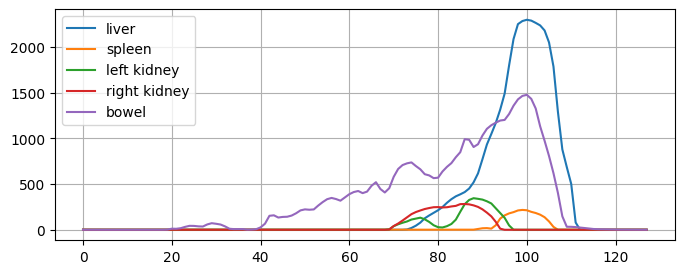

In [11]:
plt.figure(figsize=(8,3))
for o in range(5):
    plt.plot(torch.sum(logits[o], dim=[0,1]), label=names[o+1])
plt.grid()
plt.legend()

In [12]:
names

{1: 'liver', 2: 'spleen', 3: 'left kidney', 4: 'right kidney', 5: 'bowel'}

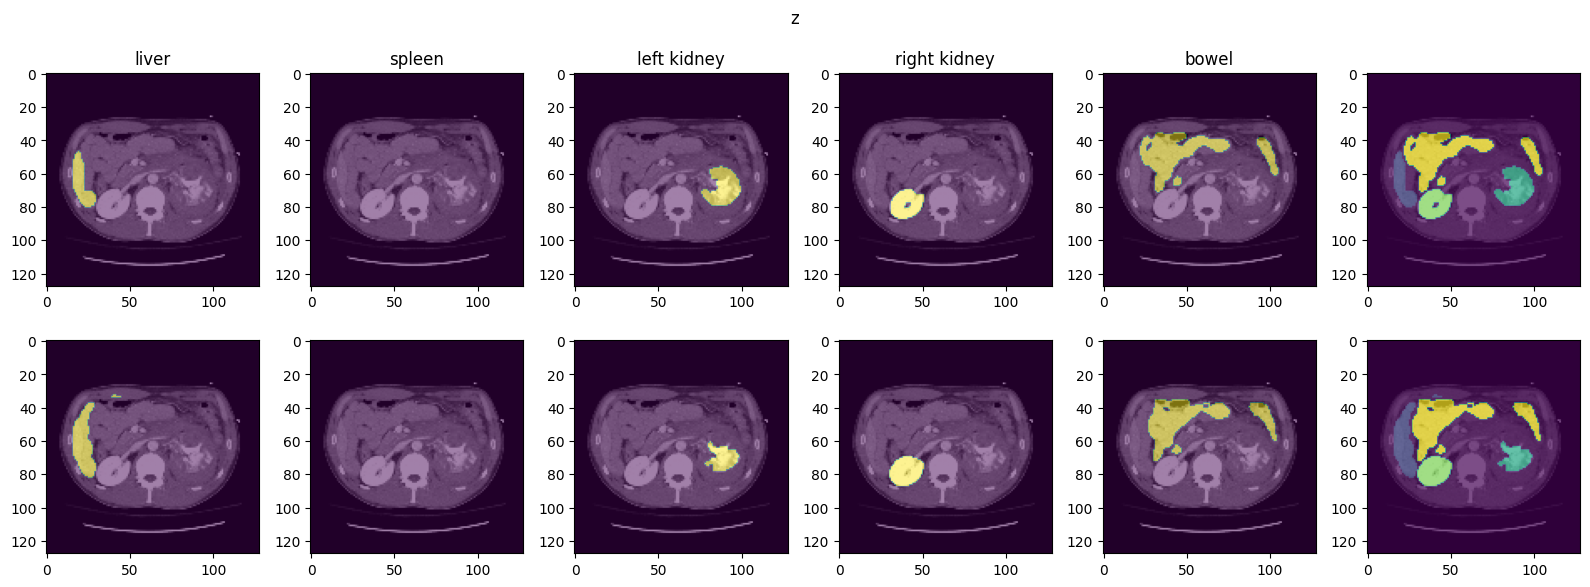

In [31]:
j = 85
th = 0.2
show_plot(images, label, logits, 'z', j, th)

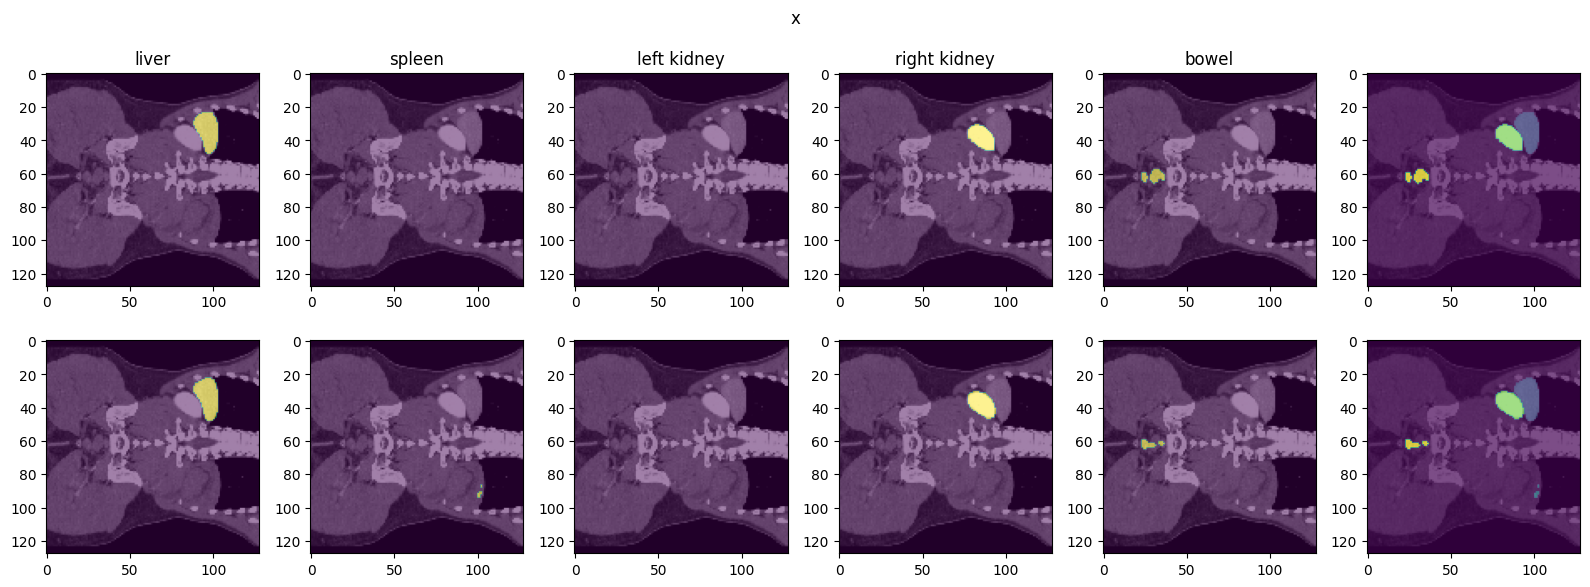

In [32]:
show_plot(images, label, logits, 'x', j, th)

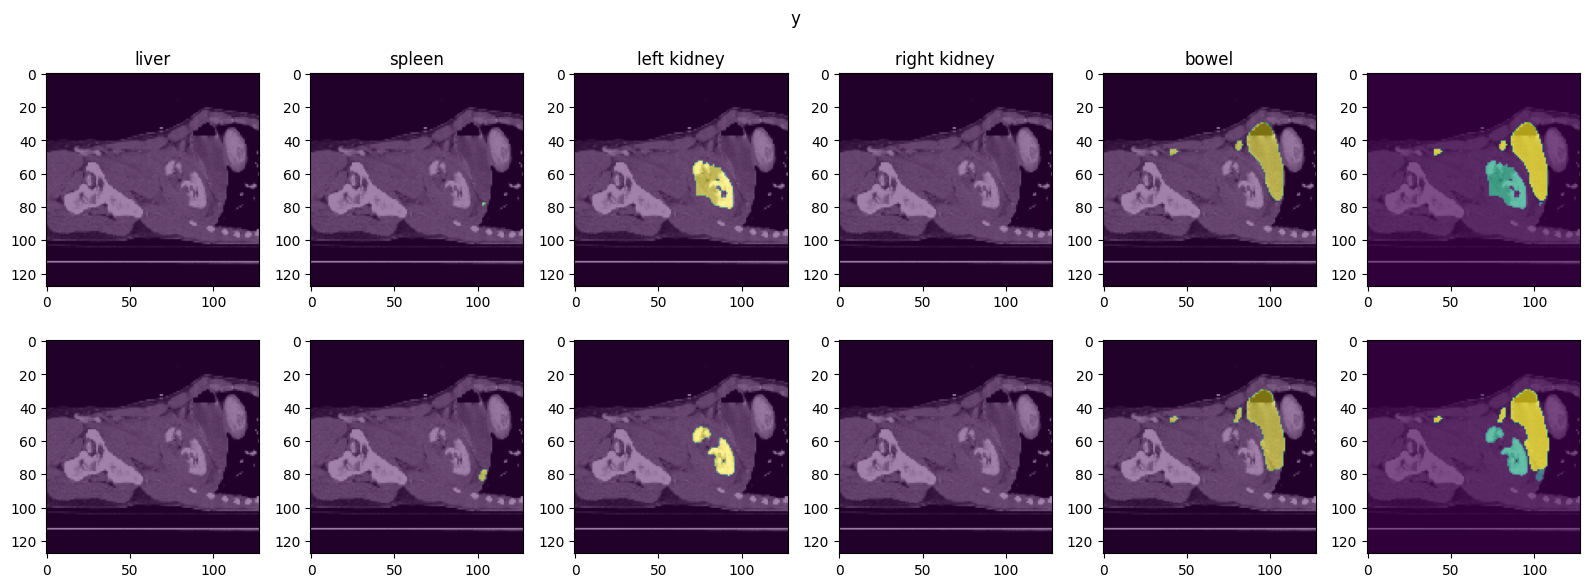

In [33]:
show_plot(images, label, logits, 'y', j, th) 

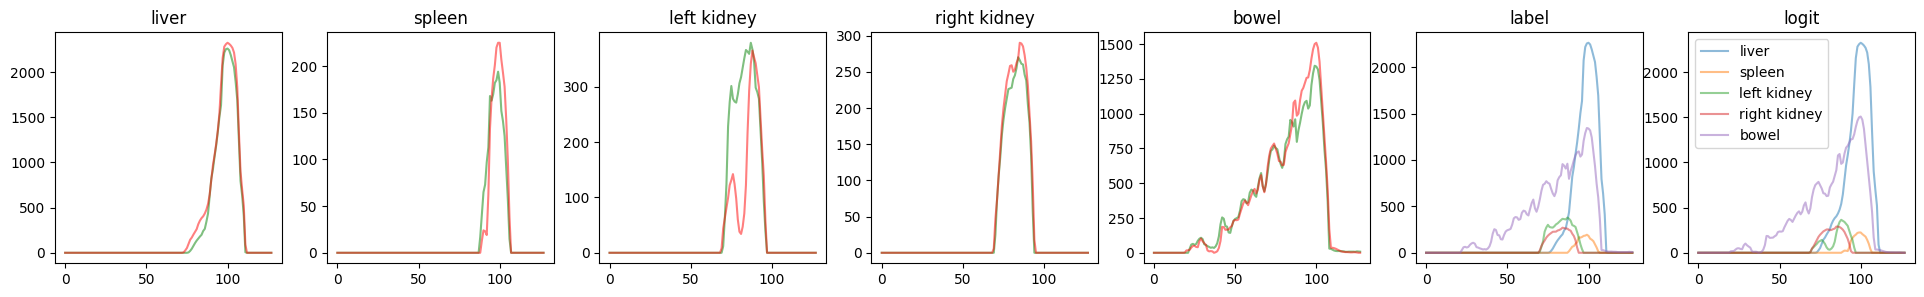

In [16]:
fig, axes = plt.subplots(1,7, figsize=(24,3))
for i in range(5):
    axes[i].plot(torch.sum(label[i], axis=[0,1]), label=names[i+1]+'-label', alpha=0.5, color='green')
    axes[i].plot(torch.sum(logits[i] > th, axis=[0,1]), label=names[i+1]+'-logit', alpha=0.5, color='red')
    axes[i].set_title(names[i+1])
    axes[5].plot(torch.sum(label[i], axis=[0,1]), label=names[i+1], alpha=0.5)
    axes[6].plot(torch.sum(logits[i] > th, axis=[0,1]), label=names[i+1], alpha=0.5)
axes[5].set_title('label')
axes[6].set_title('logit')
plt.legend();

In [17]:
for i in range(5):
    l = torch.sum(logits[i] > 0.2, axis=[0,1]).numpy()
    print(f"{names[i+1]} : {np.count_nonzero(l)/len(l) * 100:.2f}%")

liver : 30.47%
spleen : 14.06%
left kidney : 21.88%
right kidney : 20.31%
bowel : 82.81%


## cv check - For Ensemble

In [18]:
def load_model(backbone, model_file):
    model = TimmSegModel(backbone, pretrained=False)
    model = convert_3d(model)
    weight = torch.load(model_file)
    model.load_state_dict(weight)
    model = model.to(device)
    model.eval()
    return model

fold = 0

df_seg = pd.read_csv(os.path.join(data_dir, 'df_seg.csv'))

backbone_1 = 'test'
model_file_1 = "../../results/segmentations/test/test_fold0_best.pth"

backbone_2 = 'tf_efficientnetv2_s_in21ft1k'
model_file_2 = "../../result/segmentations/effv2s/model/effv2s_fold0_best.pth"

valid_ = df_seg[df_seg['fold'] == fold].reset_index(drop=True)
dataset_valid = SEGDataset(valid_, 'valid', transform=transforms_valid)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers )

model_1 = load_model(backbone_1, model_file_1)
model_2 = load_model(backbone_2, model_file_2)

In [19]:
loss_1, metrics_1, outputs_1, labels = valid_func(model_1, loader_valid)
loss_2, metrics_2, outputs_2, labels = valid_func(model_2, loader_valid)
loss_1, metrics_1, loss_2, metrics_2

smth:0.0530: 100%|██████████| 11/11 [00:20<00:00,  1.91s/it]


best th: 0.2 best dc: 0.902801803165448


smth:0.0734: 100%|██████████| 11/11 [00:20<00:00,  1.84s/it]


best th: 0.2 best dc: 0.843985965558754


(0.05303554677150466,
 0.902801803165448,
 0.07339703799648718,
 0.843985965558754)

In [20]:
labels.shape, outputs_1.shape, outputs_2.shape

(torch.Size([42, 5, 128, 128, 128]),
 torch.Size([42, 5, 128, 128, 128]),
 torch.Size([42, 5, 128, 128, 128]))

In [21]:
def score(outputs, labels, th=0.2):
    best_metrics = []
    for i in range(outputs.shape[0]):
        output = (outputs[i] > th).float()
        tmp = multilabel_dice_score(
            y_pred=output,
            y_true=labels[i],
            threshold=0.5,
        )
        best_metrics.extend(tmp)
    return np.mean(best_metrics)

In [22]:
score(outputs_1, labels)

0.8924638433036861

In [23]:
score(outputs_2, labels)

0.8417453058048073

In [24]:
i = 0.1
outputs = (outputs_1 * i + outputs_2 * (1-i))
outputs.shape

torch.Size([42, 5, 128, 128, 128])

In [25]:
score(outputs, labels)

0.8457449200730341